In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [7]:
airlines_passengers.head(3)

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [8]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

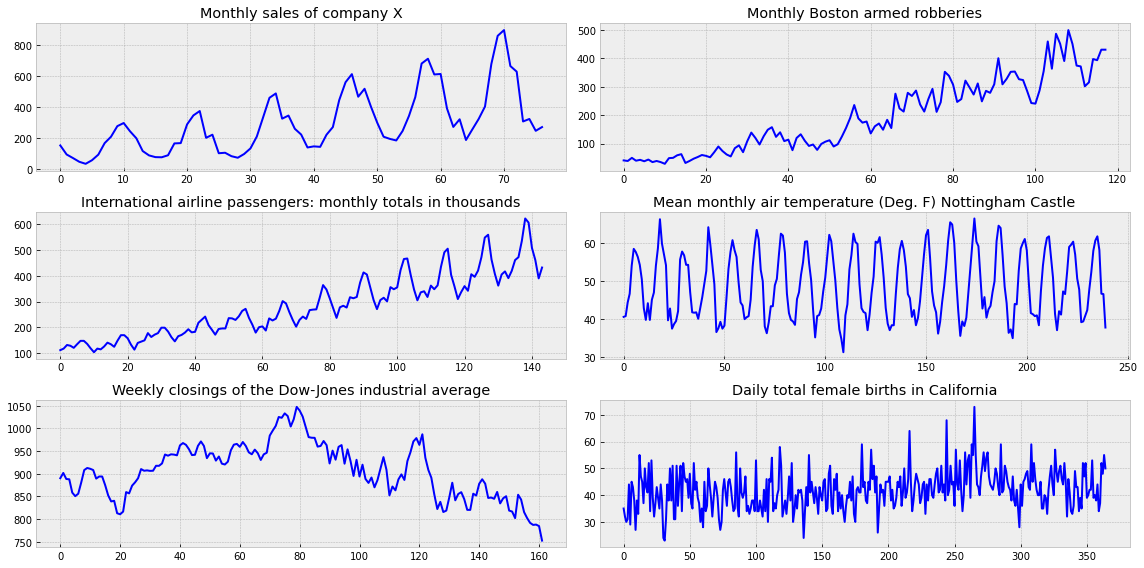

In [48]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3,2)
    for i, key in enumerate(all_series.keys()):
        col = i % 2
        row = int((i - col) / 2)
        
        ts_ax = plt.subplot2grid(layout, (row, col))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
    plt.tight_layout()   

## визуальный поиск сезонности

In [42]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

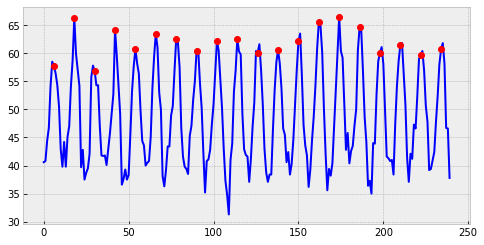

In [47]:
plot_ts_and_points(mean_monthly_temp["Deg"], 6, 12)

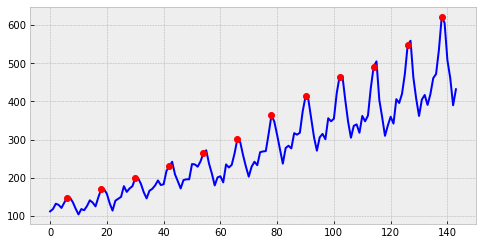

In [44]:
plot_ts_and_points(airlines_passengers["Count"], 6, 12)

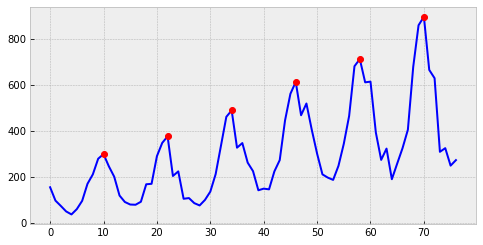

In [46]:
plot_ts_and_points(sales_of_company_x["Count"], 10, 12)

## нормализация дисперсии при помощи логарифмирования

In [50]:
from scipy.stats import boxcox
import copy

all_series_2 = copy.deepcopy(all_series)
for key, val in all_series_2.items():
    all_series_2[key] = boxcox(val, 0)

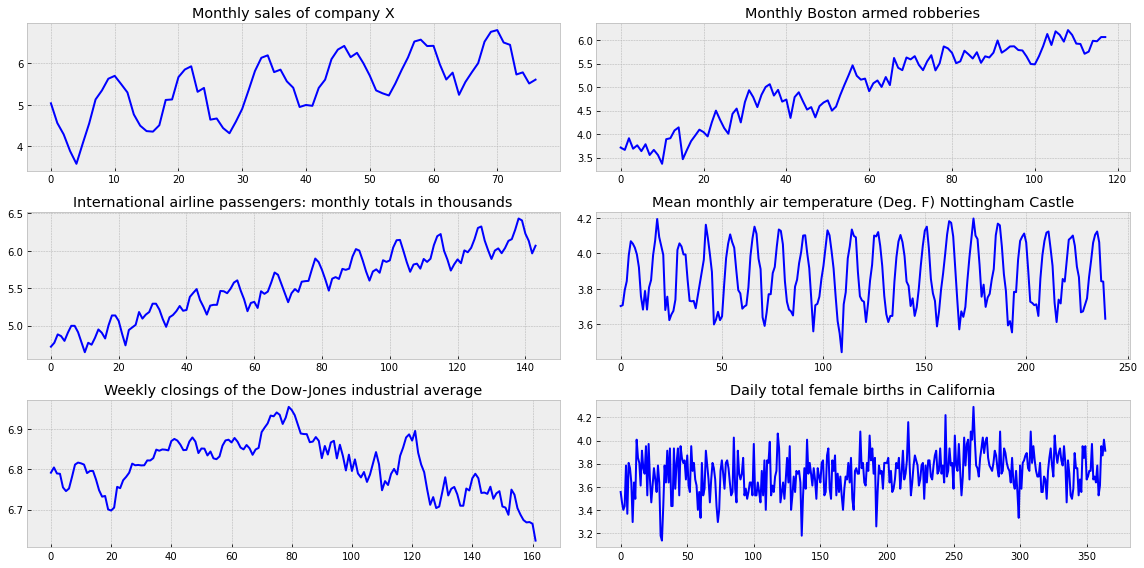

In [52]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3,2)
    for i, key in enumerate(all_series_2.keys()):
        col = i % 2
        row = int((i - col) / 2)
        
        ts_ax = plt.subplot2grid(layout, (row, col))
        pd.Series(all_series_2[key]).plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
    plt.tight_layout()  

## дифференцирование

In [55]:
all_series_3 = copy.deepcopy(all_series_2)
for key, val in all_series_3.items():
    all_series_3[key] = np.diff(val, 1)

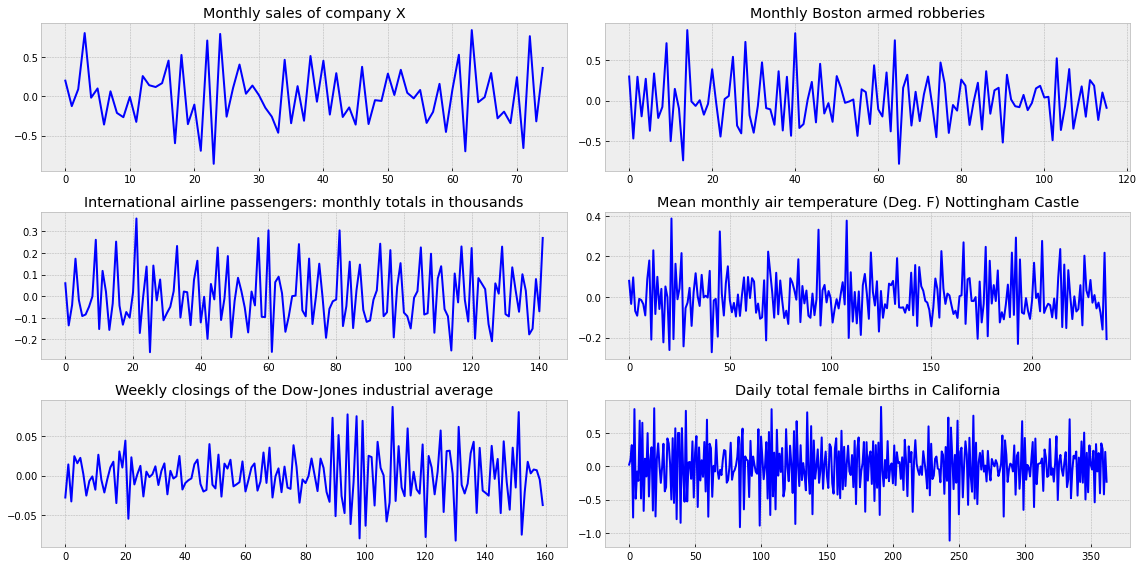

In [56]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3,2)
    for i, key in enumerate(all_series_3.keys()):
        col = i % 2
        row = int((i - col) / 2)
        
        ts_ax = plt.subplot2grid(layout, (row, col))
        pd.Series(all_series_3[key]).plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
    plt.tight_layout()  

## тест Дики-Фуллера

In [57]:
from statsmodels.tsa.stattools import adfuller

In [58]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [62]:
for key, val in all_series_3.items():
    print(f'\033[1m{key}\033[0m')
    test_stationarity(val)

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                -7.101182e+00
p-value                        4.164137e-10
#Lags Used                     1.100000e+01
Number of Observations Used    6.300000e+01
Critical Value (1%)           -3.538695e+00
Critical Value (5%)           -2.908645e+00
Critical Value (10%)          -2.591897e+00
dtype: float64
Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                -6.571432e+00
p-value                        7.918035e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.030000e+02
Critical Value (1%)           -3.495493e+00
Critical Value (5%)           -2.890037e+00
Critical Value (10%)          -2.581971e+00
dtype: float64
International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of

## Судя по графиккам после дифференцирования и значению р-value в тестах Дики-Фуллера, все ряды теперь стационарны.



Еще дополнительно построю коррелограммы по исходным сериям.

In [60]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [74]:
def tsplot(y, lags=None, figsize=(8, 6), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Monthly sales of company X


C:\Users\tukma\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


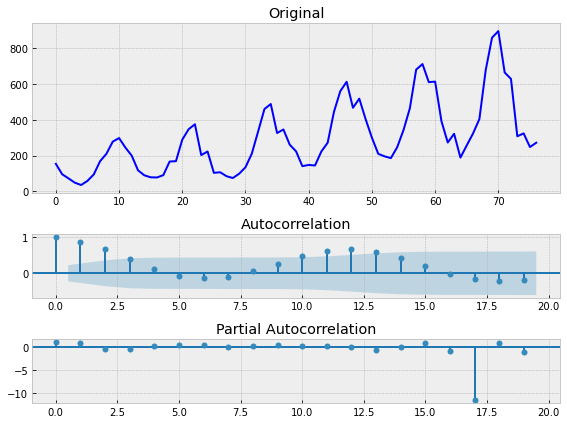

In [84]:
print("\033[1mMonthly sales of company X\033[0m")
tsplot(sales_of_company_x["Count"])

Monthly Boston armed robberies


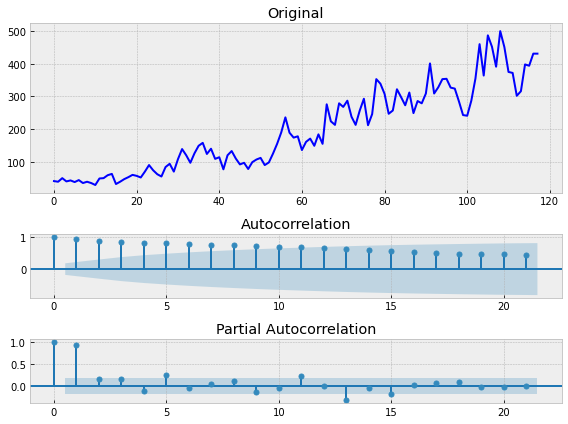

In [85]:
print("\033[1mMonthly Boston armed robberies\033[0m")
tsplot(robberies_in_boston["Count"])

International airline passengers: monthly totals in thousands


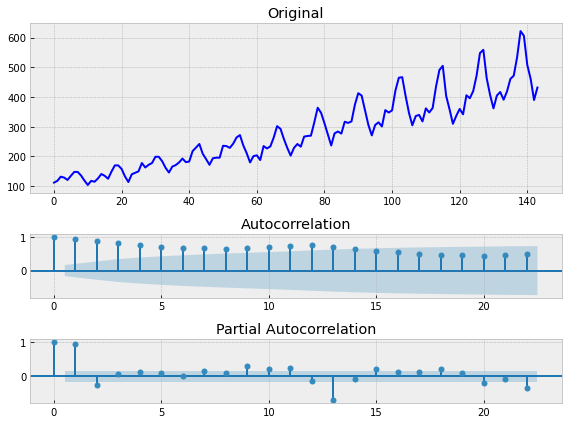

In [86]:
print("\033[1mInternational airline passengers: monthly totals in thousands\033[0m")
tsplot(airlines_passengers["Count"])

Mean monthly air temperature (Deg. F) Nottingham Castle


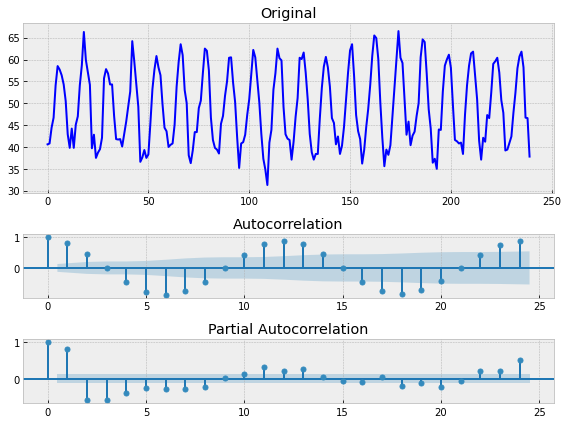

In [87]:
print("\033[1mMean monthly air temperature (Deg. F) Nottingham Castle\033[0m")
tsplot(mean_monthly_temp["Deg"])

Weekly closings of the Dow-Jones industrial average


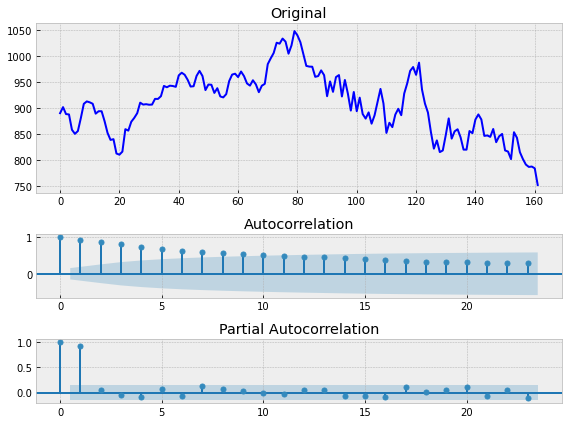

In [88]:
print("\033[1mWeekly closings of the Dow-Jones industrial average\033[0m")
tsplot(dowjones_closing["Close"])

Daily total female births in California


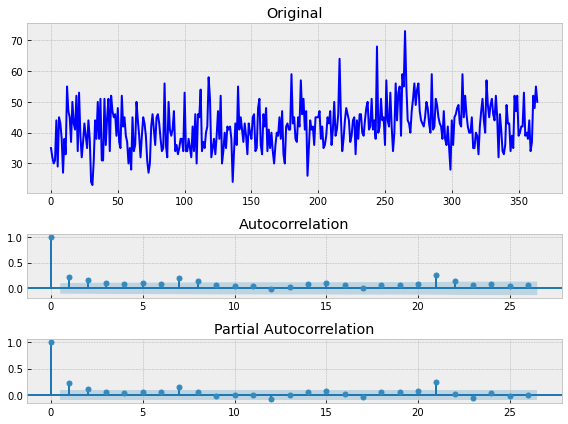

In [89]:
print("\033[1mDaily total female births in California\033[0m")
tsplot(female_births["Count"])

По автокорреляции самое резкое падение у последнего графика (рождаемость), остальные более или менее плавные.
Из графиков ежемесячных продаж и среднемесячных температур видно сезонность.